In [2]:
import torch
import os
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [5]:
from torchvision import models
from torch.optim import lr_scheduler

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**Check the avaiability of GPU**

In [7]:
torch.cuda.is_available()

True

**Transform the data in to torch tensors and normalize it**

In [8]:

transform = transforms.Compose(
            [transforms.RandomResizedCrop(224),
             transforms.ToTensor(),
             transforms.Normalize((0.485,0.465,0.406),(0.229,0.224,0.225))])


**Loading the dataset**

In [9]:
data = "D:/Jayanth/Desktop/Data"
dataset = ImageFolder(data, transform=transform)

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 7553
    Root location: D:/Jayanth/Desktop/Data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.485, 0.465, 0.406), std=(0.229, 0.224, 0.225))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: with_mask


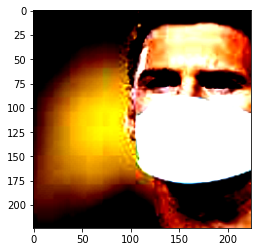

In [11]:
img,label = dataset[700]
print('Label:',dataset.classes[label])
plt.imshow(img.permute(1,2,0))


**Spliting the Dataset into Training and testing set**

In [12]:
test_size = int(0.2 * len(dataset))

In [13]:
len(dataset)

7553

In [14]:

train_set, test_set = random_split(dataset,(6000,1553))

In [15]:
len(train_set)

6000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: with_mask


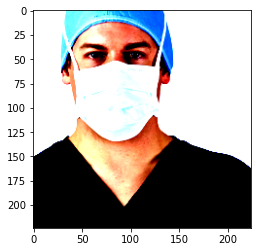

In [16]:
img,label = train_set[700]
print('Label:',dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [17]:
len(test_set)

1553

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: without_mask


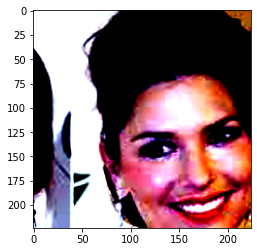

In [18]:
img,label = test_set[1238]
print('Label:',dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [19]:
img.shape

torch.Size([3, 224, 224])

**Preparing the training and Testing Loader**

In [20]:
trainloader = DataLoader(train_set,batch_size=4,shuffle=True,num_workers=2)

testloader = DataLoader(test_set,batch_size =4,num_workers=2)

In [21]:
len(trainloader)

1500

In [22]:
len(testloader)

389

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


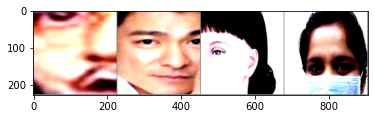

without_mask without_mask with_mask with_mask


In [25]:
def show(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
    plt.show()

img, label =next(iter(trainloader))
show(torchvision.utils.make_grid(img))
classes = ('with_mask','without_mask')
print(' '.join(classes[label[j]] for j in range(4)))

**CNN**
- The CNN is going to have 3 Convlutional layers, each followed by ReLu nonlinearity, and a fully connected layer. </br>
- each poolying layer halves both height and width of the image. so by using the pllolying layer the height and width are 1/4 of the original size.



In [33]:
# 3 convolution layer, Maxpool and fully connected layer


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
               
        # Instantiate three convolution layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3, padding=1)
                      
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1)
          #Instantiate a max pooling layer  
        self.pool = nn.MaxPool2d(2,2)
        
                
        #Instantiate a fully connected Layer
        self.fc = nn.Linear(28 * 28 * 128, 2)
                
      
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
         
        # Prepare the image for the fully connected layer
        x = x.view(-1, 28 * 28 * 128)
    
        #Apply the fully connected Layer and return the result
        
        x = self.fc(x)
        return x

In [34]:

net = Net()


In [35]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

**Optimize and Loss Function**

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001, momentum=0.9)

**Training CNN**

**Evaluating the training set**

In [37]:
# Trainiung a CNN

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train_loss = []

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        
        loss.backward()
        optimizer.step()
        #print each loss
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    print('Epoch/passing the training set:', epoch)
    print('Loss  :', epoch_loss)
    print('--' * 15)
    train_loss.append(epoch_loss)    

        
end.record()

torch.cuda.synchronize()
print('Finished')

print(start.elapsed_time(end))

Epoch/passing the training set: 0
Loss  : 0.4936070603430271
------------------------------
Epoch/passing the training set: 1
Loss  : 0.4688616032848755
------------------------------
Epoch/passing the training set: 2
Loss  : 0.44355690661196906
------------------------------
Epoch/passing the training set: 3
Loss  : 0.43529649459694825
------------------------------
Epoch/passing the training set: 4
Loss  : 0.39773588358735046
------------------------------
Epoch/passing the training set: 5
Loss  : 0.36504413991173107
------------------------------
Epoch/passing the training set: 6
Loss  : 0.3594117067428306
------------------------------
Epoch/passing the training set: 7
Loss  : 0.3341240190707225
------------------------------
Epoch/passing the training set: 8
Loss  : 0.3273124204329215
------------------------------
Epoch/passing the training set: 9
Loss  : 0.31711779280123303
------------------------------
Finished
0.003008000086992979


In [38]:
correct =  0.0
total = 0.0
predictions = []
predicts = []
actuals = []
net.eval()
for i, data in enumerate(trainloader,0):
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct +=(predicted == labels).sum().item()
    predicts.append(predicted[0])
    actuals.append(labels[0])

print('The training set accuracy of the network : ', 100 * correct/total)

The training set accuracy of the network :  87.51666666666667


**Evaluating the testing set**

In [39]:
correct =  0.0
total = 0.0

net.eval()
test_loss = []
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(testloader,0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct +=(predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(testloader)
    #print('Epoch/passing the test set:', epoch)
    #print('Loss  :', epoch_loss)
    #print('--' * 15)
    test_loss.append(epoch_loss)   

print('The testing set accuracy of the network : ', 100 * correct/total)
    

The testing set accuracy of the network :  87.16033483580168


Text(0.5, 1.0, 'Train vs Test Losses')

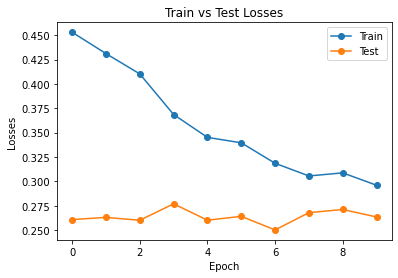

In [52]:
plt.plot(train_loss,'-o')
plt.plot(test_loss,'-o')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')

**Testing a random batch**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


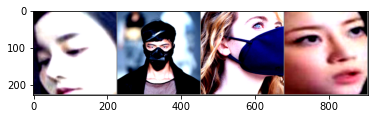

Actual Labels: without_mask  with_mask  with_mask  without_mask


In [47]:
dataiter = iter(testloader)
images,label = dataiter.next()
show(torchvision.utils.make_grid(images))

print('Actual Labels:', '  '.join(classes[label[j]] for j in range(4)))



In [48]:
output = net(images)
_, predicted = torch.max(output.data,1)

print('Predicted Labels', '  '.join(classes[predicted[j]] for j in range(4)))

Predicted Labels without_mask  with_mask  with_mask  without_mask


**Predicting the test loader**

In [56]:
pred_label = []
actual_label = []

for i, data in enumerate(testloader,0):
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data,1)
    pred_label.append(predicted[0])
    actual_label.append(labels[0])
                         
    if (classes[predicted[0]] == classes[labels[0]]):
               
        print('Model made right prediction    ' + classes[predicted[0]])
    else:
        print('Wrong prediction and the correct lable is  ' + classes[labels[0]])

Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    with_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    with_mask
Model made right prediction    without_mask
Model made right prediction    with_mask
Wrong prediction and the correct lable is  without_mask
Model made right prediction    with_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    with_mask
Wrong prediction and the correct lable is  without_mask
Model made right prediction    with_mask
Model made right prediction    with_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction    without_mask
Model made right prediction  